# Illustration of the entropy adaptation for Gaussian targets

## Ill-conditioned Gaussian target with independent mass matrix



Imports

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from adaptive_linear_preconditioned_hmc import AdaptivePreconditionedHamiltonianMonteCarlo
from tensorflow_probability.python.experimental.mcmc.preconditioned_hmc import PreconditionedHamiltonianMonteCarlo
tfd = tfp.distributions
tfb = tfp.bijectors

Define hyperparameters

In [2]:
NUM_CHAINS = 10
NUM_LEAPFROG_STEPS = 5
DIMS = 50
NUM_RESULTS = 10000
LEARNING_RATE = .0005


Define ill-conditioned Gaussian target

In [3]:
dtype = tf.float32
diags = np.exp(3*np.linspace(0., DIMS-1, DIMS) / (DIMS-1) *np.log(10))
std = tf.Variable(diags, dtype=dtype, name='std')
target_dist = tfd.MultivariateNormalDiag(
          loc=tf.zeros(DIMS), scale_diag=std)
target = target_dist.log_prob
eigenvalues_target, _ = tf.linalg.eigh(target_dist.covariance())
smooth_param = 1/eigenvalues_target[0]
init_positions = tf.random.normal([NUM_CHAINS, DIMS])/tf.sqrt(smooth_param)


Define parameters for preconditioning

In [4]:
pre_cond_scale_diag_init = tfd.Normal(
  loc = 0., scale = 1).sample(DIMS) * tf.math.pow(tf.cast(DIMS, tf.float32), -1 / 3)
pre_cond_scale_diag = tf.Variable(
  initial_value = pre_cond_scale_diag_init * tf.ones([DIMS]))
pre_cond_params = [pre_cond_scale_diag]

#Define a function that returns the precision cholesky factor
#of the momentum distribution as well as the momentum distribution iself
#We assume here a diagonal mass matrix
def make_pre_cond_fn(params):
  pre_cond_scale_diag = params[0]
  pre_cond_operator = tf.linalg.LinearOperatorDiag(diag = pre_cond_scale_diag)
  momentum_distribution = tfp.experimental.distributions.MultivariateNormalPrecisionFactorLinearOperator(
    loc = tf.cast(tf.zeros([NUM_CHAINS, DIMS]), dtype),
    precision_factor = pre_cond_operator
  )
  return pre_cond_operator, momentum_distribution



Define adaptive HMC sampler and sampling function

In [5]:
precond_hmc = AdaptivePreconditionedHamiltonianMonteCarlo(
    target_log_prob_fn = target,
    make_pre_cond_fn = make_pre_cond_fn,
    params = pre_cond_params,
    step_size = 1.,
    num_leapfrog_steps = NUM_LEAPFROG_STEPS,
    learning_rate = LEARNING_RATE,
    opt_acceptance_rate = .7,
    beta_learning_rate = .1,
)

#For illustatation, we keep here track of different kernel results of
#the adapted parallel chains that can be useful for diagnostics
def trace_fn(states, previous_kernel_results):
    return (
      previous_kernel_results.is_accepted,
      previous_kernel_results.log_accept_ratio,
      previous_kernel_results.proposed_results.mcmc_loss,
      previous_kernel_results.proposed_results.entropy_weight,
      previous_kernel_results.proposed_results.proposal_log_prob,
      previous_kernel_results.proposed_results.eigenvalue_estimate,
      previous_kernel_results.proposed_results.log_det_jac_transformation,
      previous_kernel_results.proposed_results.trace_residual_log_det,
      previous_kernel_results.proposed_results.params[0][0],
      previous_kernel_results.proposed_results.grads[0][0]
    )

@tf.function
def run_precond_hmc_chain():
  samples, kernel_results = tfp.mcmc.sample_chain(
    num_results=NUM_RESULTS,
    num_burnin_steps=0,
    current_state=tf.cast(init_positions, dtype),
    kernel=precond_hmc,
    num_steps_between_results=0,
    trace_fn = trace_fn,
    return_final_kernel_results=False)

  return samples, kernel_results

Run adaptive HMC chain

In [6]:
def compute_ess(samples, dt):
    ess = tfp.mcmc.effective_sample_size(samples)
    min_ess_per_sec = tf.reduce_min(tf.reduce_mean(ess, 0)) / dt
    min_ess = tf.reduce_min(tf.reduce_mean(ess, 0))
    mean_ess = np.mean(ess)
    return ess, mean_ess, min_ess, min_ess_per_sec


start_time_hmc_adapt = time.time()
samples_hmc_adapt, results_hmc_adapt = run_precond_hmc_chain()
(is_accepted_hmc_adapt,\
    log_accept_ratio_hmc_adapt,\
    mcmc_loss_hmc_adapt,\
    entropy_weight_hmc_adapt,\
    proposal_log_prob_hmc_adapt,\
    eigenvalue_estimate_hmc_adapt,\
    log_det_jac_transformation_hmc_adapt,\
    trace_residual_log_det_hmc_adapt,\
    params_hmc_adapt,\
    grads_hmc_adapt
 ) = results_hmc_adapt
time_hmc_adapt = time.time() - start_time_hmc_adapt
ess_hmc_adapt, _, min_ess_hmc_adapt, \
min_ess_per_sec_hmc_adapt \
  = compute_ess(samples_hmc_adapt, time_hmc_adapt)



Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it with `scale_diag` directly instead.


Define learned (adapted) HMC sampler

In [7]:
pre_cond_operator, momentum_distribution = make_pre_cond_fn(pre_cond_params)

learned_precond_hmc = PreconditionedHamiltonianMonteCarlo(
  target_log_prob_fn = target,
  step_size = precond_hmc._impl.inner_kernel._step_size.numpy(),
  num_leapfrog_steps = NUM_LEAPFROG_STEPS,
  momentum_distribution = momentum_distribution
)

def trace_fn_learned(states, previous_kernel_results):
    return (previous_kernel_results.is_accepted,
            previous_kernel_results.accepted_results.target_log_prob)

@tf.function
def run_learned_precond_hmc_chain():
  samples, kernel_results = tfp.mcmc.sample_chain(
    num_results=NUM_RESULTS,
    num_burnin_steps=0,
    current_state=samples_hmc_adapt[-1],
    kernel=learned_precond_hmc,
    num_steps_between_results=0,
    trace_fn = trace_fn_learned,
    return_final_kernel_results=False)

  return samples, kernel_results


Run learned HMC sampler

In [8]:
start_time_hmc_learned = time.time()
samples_hmc_learned, kernel_results_hmc_learned \
  = run_learned_precond_hmc_chain()
time_hmc_learned = time.time() - start_time_hmc_learned

#Compute ESS statistics
ess_hmc_learned, mean_ess_hmc_learned, min_ess_hmc_learned, \
min_ess_per_sec_hmc_learned \
  = compute_ess(samples_hmc_learned, time_hmc_learned)
print('iid Gaussian minESS/sec: {}'.format(min_ess_per_sec_hmc_learned))


iid Gaussian minESS/sec: 0.8141636848449707


## Correlated Gaussian target with full mass matrix



In [9]:
index_points = np.expand_dims(np.linspace(0., 4.,  DIMS), -1)
gp_cov_matrix_=np.zeros([DIMS,DIMS])
for i in range(0,DIMS):
  for j in range(0,DIMS):
    gp_cov_matrix_[i,j]=np.exp(-.5*(index_points[i]-index_points[j])**2/.16)
for i in range(0,DIMS):
  gp_cov_matrix_[i,i]=gp_cov_matrix_[i,i]+.01

target_dist = tfd.MultivariateNormalTriL(
  loc = tf.zeros(DIMS), scale_tril = tf.linalg.cholesky(tf.cast(gp_cov_matrix_, dtype)))
target = target_dist.log_prob

def hessian_potential(z):
  return tf.linalg.inv(tf.cast(gp_cov_matrix_, dtype))

#eigenvalues of target and initialise initial samples and parameters
eigenvalues_target, _ = tf.linalg.eigh(target_dist.covariance())
smooth_param = 1/eigenvalues_target[0]
init_positions = tf.random.normal([NUM_CHAINS, DIMS])/tf.sqrt(smooth_param)


Define parameters for preconditioning

In [10]:
#params for preconditinong
pre_cond_scale_diag_init = tfd.Normal(
  loc = 0., scale = .1).sample(DIMS)/NUM_LEAPFROG_STEPS
pre_cond_tril = tf.Variable(
    initial_value =pre_cond_scale_diag_init * tf.eye(DIMS))
pre_cond_params = [pre_cond_tril]

#Define a function that returns the precision cholesky factor
#of the momentum distribution as well as the momentum distribution iself
#We assume here a dense matrix mass matrix
def make_pre_cond_fn(params):
  pre_cond_tril = params[0]
  pre_cond_operator = tf.linalg.LinearOperatorLowerTriangular(tril = pre_cond_tril)
  momentum_distribution = tfp.experimental.distributions.MultivariateNormalPrecisionFactorLinearOperator(
    loc = tf.cast(tf.zeros([NUM_CHAINS, DIMS]), dtype),
    precision_factor = pre_cond_operator
  )
  return pre_cond_operator, momentum_distribution



Define adaptive HMC sampler and sampling function

In [11]:
precond_hmc = AdaptivePreconditionedHamiltonianMonteCarlo(
    target_log_prob_fn = target,
    make_pre_cond_fn = make_pre_cond_fn,
    params = pre_cond_params,
    step_size = 1.,
    num_leapfrog_steps = NUM_LEAPFROG_STEPS,
    learning_rate = LEARNING_RATE,
    opt_acceptance_rate = .7,
    beta_learning_rate = .1,
)

#For illustatation, we keep here track of different kernel results of
#the adapted parallel chains that can be useful for diagnostics
def trace_fn(states, previous_kernel_results):
    return (
      previous_kernel_results.is_accepted,
      previous_kernel_results.log_accept_ratio,
      previous_kernel_results.proposed_results.mcmc_loss,
      previous_kernel_results.proposed_results.entropy_weight,
      previous_kernel_results.proposed_results.proposal_log_prob,
      previous_kernel_results.proposed_results.eigenvalue_estimate,
      previous_kernel_results.proposed_results.log_det_jac_transformation,
      previous_kernel_results.proposed_results.trace_residual_log_det,
      previous_kernel_results.proposed_results.params[0][0],
      previous_kernel_results.proposed_results.grads[0][0]
    )

@tf.function
def run_precond_hmc_chain():
  samples, kernel_results = tfp.mcmc.sample_chain(
    num_results=NUM_RESULTS,
    num_burnin_steps=0,
    current_state=tf.cast(init_positions, dtype),
    kernel=precond_hmc,
    num_steps_between_results=0,
    trace_fn = trace_fn,
    return_final_kernel_results=False)

  return samples, kernel_results

Run adaptive HMC chain

In [12]:
def compute_ess(samples, dt):
    ess = tfp.mcmc.effective_sample_size(samples)
    min_ess_per_sec = tf.reduce_min(tf.reduce_mean(ess, 0)) / dt
    min_ess = tf.reduce_min(tf.reduce_mean(ess, 0))
    mean_ess = np.mean(ess)
    return ess, mean_ess, min_ess, min_ess_per_sec


start_time_hmc_adapt = time.time()
samples_hmc_adapt, results_hmc_adapt = run_precond_hmc_chain()
(is_accepted_hmc_adapt,\
    log_accept_ratio_hmc_adapt,\
    mcmc_loss_hmc_adapt,\
    entropy_weight_hmc_adapt,\
    proposal_log_prob_hmc_adapt,\
    eigenvalue_estimate_hmc_adapt,\
    log_det_jac_transformation_hmc_adapt,\
    trace_residual_log_det_hmc_adapt,\
    params_hmc_adapt,\
    grads_hmc_adapt
 ) = results_hmc_adapt
time_hmc_adapt = time.time() - start_time_hmc_adapt
ess_hmc_adapt, _, min_ess_hmc_adapt, \
min_ess_per_sec_hmc_adapt \
  = compute_ess(samples_hmc_adapt, time_hmc_adapt)



Define learned (adapted) HMC sampler

In [13]:
pre_cond_operator, momentum_distribution = make_pre_cond_fn(pre_cond_params)

learned_precond_hmc = PreconditionedHamiltonianMonteCarlo(
  target_log_prob_fn = target,
  step_size = precond_hmc._impl.inner_kernel._step_size.numpy(),
  num_leapfrog_steps = NUM_LEAPFROG_STEPS,
  momentum_distribution = momentum_distribution
)

def trace_fn_learned(states, previous_kernel_results):
    return (previous_kernel_results.is_accepted,
            previous_kernel_results.accepted_results.target_log_prob)

@tf.function
def run_learned_precond_hmc_chain():
  samples, kernel_results = tfp.mcmc.sample_chain(
    num_results=NUM_RESULTS,
    num_burnin_steps=0,
    current_state=samples_hmc_adapt[-1],
    kernel=learned_precond_hmc,
    num_steps_between_results=0,
    trace_fn = trace_fn_learned,
    return_final_kernel_results=False)

  return samples, kernel_results

Plot the inverse mass matrix

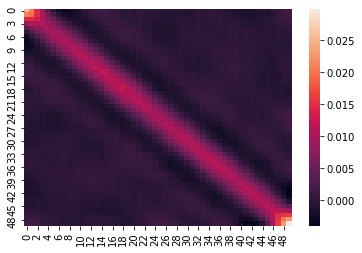

In [14]:
C_adapt = pre_cond_operator.to_dense().numpy()
inv_M_adapt = np.matmul(C_adapt,C_adapt.transpose())

#compute transformed target
transformed_hessian=tf.matmul(tf.matmul(C_adapt, tf.linalg.inv(target_dist.covariance()),
                                        adjoint_a=True), C_adapt)
transformed_eigenvalues,_=tf.linalg.eigh(transformed_hessian)

#plot inverse mass matrix
sns.heatmap(inv_M_adapt)
plt.show()


Run learned HMC sampler

In [15]:
start_time_hmc_learned = time.time()
samples_hmc_learned, kernel_results_hmc_learned \
  = run_learned_precond_hmc_chain()
time_hmc_learned = time.time() - start_time_hmc_learned

#Compute ESS statistics
ess_hmc_learned, mean_ess_hmc_learned, min_ess_hmc_learned, \
min_ess_per_sec_hmc_learned \
  = compute_ess(samples_hmc_learned, time_hmc_learned)
print('correlated Gaussian minESS/sec: {}'.format(min_ess_per_sec_hmc_learned))



correlated Gaussian minESS/sec: 3.060520887374878
